**Machine Learning Basic Principles 2018 - Data Analysis Project Report**

**Note to peer grader:** 

The data files (train_data.csv, train_labels.csv, test_data.csv) as well as the images provided in the zip-file need to be in the working directory for the code to run. (Usually in the same directory as the notebook itself.)

**Guidelines on installing the required packages for Linux using the terminal:**

Install Conda/Anaconda. Instructions here: https://conda.io/docs/user-guide/install/linux.html

Anaconda should require everything you need except Tensorflow and Keras. Tensorflow only supports Python3.6 while Conda is by default for Python3.6. For this purpose, you need to make a virtual environment for python3.6 in Conda.

Create a suitable environment with the command:
conda create -n python36 anaconda python=3.6

"python36" is the name of the environment (you can change it to anything you like). The word "anaconda" makes it so that anaconda is installed in the new environment. 

Then activate the environment with:
conda activate python36

Then install tensorflow:
pip install --upgrade tensorflow

Then install Keras:
pip install --upgrade Keras

If you want to go back to the default Conda environment, you can do so by the command "conda deactivate"

These require pip to be installed. If you don't have it, you can install it with the command "conda install pip".

Remember to run the notebook only in the python36 environment! So run the above command to activate the environment first for each session, only then start jupyter with "jupyter notebook".

# Comparing semi-supervised learning via Gaussian Mixture Model Clustering with supervised methods in music genre classification


## Abstract

Automatic music genre classification is a problem that has many practical applications and for which machine learning can be applied. In this work we attempt to train a classifier for the problem that combines supervised and unsupervised machine learning methods We use gaussian mixture model fuzzy clustering as an unsupervised method and logistic regression, linear discriminant analysis and neural networks as a supervised method. However, we fail to obtain good results with clustering, so we settle with comparing the methods with each other individually. Simple linear logistic regression proved to be the best of the methods attempted.



## 1. Introduction

Composing music is a challenging realm where human creativity gets to manifest and which requires special training. There might be general guidelines as to how to compose music pieces but there are not exact rules to build up on, and as such generating this might be a challenging activity for machines, and nevertheless of one of the important steps in that process is for the machine to recognize the musical structure. If we are to be able to conduct and design algorithms that is capable of constructing musical structures, we can optimize music platforms more efficiently (Engel et al., 2018). 

Music information retrieval is a broad field of research, and the main thread is to extract information from songs. This can in fact have different applications such as music transcription, copyright monitoring, music management  (for example to find the composer)
Such algorithms are an important part of digital music platforms  (Engel et al., 2018). For example to identify song moods and emotions as well as music recommendation systems, playlist generation, studying the statistical relationship between melody and harmony and optimizing song search. Such measurements are key for such as Spotify, Soundcloud and Apple music (Mintz et al., 2018). 
However most of current approaches that tackle these problems, build on user input or song file metadata which can have low scalability and are highly subjective, given that more than 75000 new albums are released every year in US alone.  Therefore automatic techniques for genre classification are required. 

This project is particularly interesting since the kind of data is different from the data contexts with which we have worked before. Studying how musical structure can be defined in terms of a variety of technical features will further add to our understanding of music information (Engel et al, 2018).
 Conducting this project will help us strengthen our intuition of multi classification algorithms and model tuning, as well as how a machine learning pipeline is structured and organized. 
 
The song features are divided into training set and testing set. The training set is used to train the classifiers, which are logistic regression and neural networks. Using the testing set we are going to find the accuracy of the classifier (Engel et al,.2018).

Our primary goal for this project was to attempt a similar semi-supervised approach than in (Poria et al., 2013), which combines unsupervised clustering with supervised classification. However, we fail to obtain good results with our clustering method, Gaussian Mixture Model based fuzzy clustering, so we compare the intended machine learning methods to each other individually. These methods include, in addition to clustering, logistic regression, linear discriminant analysis and a multilayer perceptron neural network. None of the methods seem to perform particularly well, with simple linear logistic regression offering the best predictive power (Mintz et al., 2018).


## 2. Data analysis



### 2.1. Data visualization

Some two dimensional visualizations of the data are presented in the four scatter plots below, as output of the code. The dimensionality reduction has been done with LDA. The information value of these projected images is however questionable due to the likely significant loss of information that occurs when reducing the number of dimensions from 244 to just 2. However, we can observe that at least some kind of separation exists between the classes.

Lowermost is also a bar plot of the class frequencies. It shows significant class imbalance with class 1 (Pop/Rock) containing around half of the data points.

![scatter_1](scatter1.png)
![scatter_2](scatter2.png)
![scatter_3](scatter4.png)
![scatter_all](scatter_all.png)

![barplot](barplot.png)

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from sklearn import preprocessing
from numpy import array

import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import LocalOutlierFactor
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

/home/antti/Programs/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Functions for loading the data, scaling, and removing undesirable features and outliers (which were deetermined by methods presented later)


# returns a list of feature indices from which the bad features are excluded
# if strict is False, only prunes the trivially useless and harmful features, if True, prunes some more
def get_features_to_take(strict):
    n_features = 264

    features_mostly_constant_value = [23, 47, 71, 95, 119, 143, 167, 240, 253] + list(range(204,216)) # these features have an identical value for most data points, so they easily cause computational difficulties (e.g. with matrix inversion), especially when you happen to randomly select a subset of data points where all elements have the same value
    features_no_variance = list(range(216,220)) # these features had all identical values for all data points, so they are not only useless, but harmful
    features_to_skip = features_no_variance
    if strict:
        features_to_skip = features_no_variance + features_mostly_constant_value
    features_to_take = np.array([i for i in range(n_features) if not i in features_to_skip]) 
    return features_to_take

# returns train data from which undesirable features have been pruned out
def load_train_data_as_arrays(project_folder="", subfolder=""):
    df_train_data=pd.read_csv(project_folder+subfolder+"train_data.csv", delimiter =None, header=None, index_col=False)
    df_train_labels=pd.read_csv(project_folder+subfolder+"train_labels.csv", delimiter =None, header=None, index_col=False)

    # check if there are null values
    print("Null values in train data: ", df_train_data.isnull().values.any())
    print("Null values in train labels: ", df_train_labels.isnull().values.any())
    
    #columns_to_take = features_to_take()
    X_train = np.array(df_train_data.values)#[:,columns_to_take]
    y_train = np.array(df_train_labels.values).ravel()
    return X_train, y_train

# returns test data from which undesirable features have been pruned out
def load_test_data_as_array(project_folder="", subfolder=""):
    df_test_data=pd.read_csv(project_folder+subfolder+"test_data.csv", delimiter =None, header=None, index_col=False)
    
    # check for null values
    print("Null values in test data: ", df_test_data.isnull().values.any())
    #columns_to_take = features_to_take()
    X_test = np.array(df_test_data.values)#[:,columns_to_take]
    return X_test

# main function for loading data, return all data that has been scaled and from which outliers and bad features have been removed
def load_and_scale_data(project_folder="", subfolder=""):
    X_train, y_train = load_train_data_as_arrays(project_folder=project_folder, subfolder=subfolder)
    
    X_test = load_test_data_as_array(project_folder=project_folder, subfolder=subfolder)
    X_all = np.concatenate((X_train, X_test), axis=0)

    outliers_in_test_data = [9580, 6631, 9366, 9755, 10509, 10142, 10556, 7307]

    other_than_outliers = np.array([i for i in range(X_all.shape[0]) if not i in outliers_in_test_data])
    X_all_outliers_removed = X_all[other_than_outliers]

    # with with not outliers
    scaler = StandardScaler().fit(X_all_outliers_removed)

    X_all_scaled = scaler.transform(X_all)
    X_all_scaled_outliers_removed = X_all_scaled[other_than_outliers]

    N_train = X_train.shape[0]
    return X_all_scaled, y_train, N_train, X_all_scaled_outliers_removed

# g for global, otherwise there will certainly be bugs were the values of these are mistakenly changed
X_all_g, y_train_g, N_train_g, X_all_outliers_removed_g = load_and_scale_data()

features_to_take_g = get_features_to_take(strict=False)
features_to_take_strict_g = get_features_to_take(strict=True)

# stricter pruning of features (p is for "pruned")
X_all_pg = X_all_g[:,features_to_take_strict_g]
X_all_outliers_removed_pg = X_all_outliers_removed_g[:,features_to_take_strict_g]
X_train_pg = X_all_pg[:N_train_g]
X_test_pg = X_all_pg[N_train_g:]

# only totally useless features removed
X_all_g = X_all_g[:,features_to_take_g]
X_all_outliers_removed_g = X_all_outliers_removed_g[:,features_to_take_g]
X_train_g = X_all_g[:N_train_g]
X_test_g = X_all_g[N_train_g:]



Null values in train data:  False
Null values in train labels:  False
Null values in test data:  False


In [3]:
# function for plotting scatter plots

# Plots 2 dimensional scatter plot of the music data
# Parameters:
# classes: python list representing the classes we want to plot, uses only points corresponding these classes in dimensionality reduction. USES ACTUAL CLASS LABELS, LABEL 0 MEANS THE UNLABELED DATA
# lda: if True, uses LDA, otherwise PCA
# add_test_data: if true, plot the unlabeled test data alongside the labeled data, however this data is not used for fitting the dimensionality reduction model
# feature_subset: recognizes values "rhythm", "chroma" and "MFCCs", which correspond to subsets of features explained in the assignment PDF. If this argument is given, the function uses only those features.
# weights: if set, draws circles around the data points whose sizes are determined by weights
def scatter2dim(classes, lda=False, add_test_data=False, feature_subset=None, weights=np.array([]), remove_test_outliers=False):

    marker_size = 3

    # in the following n stands for "not reduced" (two dimensionality two)
    X_all, y, N_train, X_all_outliers_removed = X_all_g, y_train_g, N_train_g, X_all_outliers_removed_g
    if remove_test_outliers:
        X_all = X_all_outliers_removed
    N_all = X_all.shape[0]
    y = np.concatenate((y, np.zeros(N_all-N_train))) # extend y so that it has 0 for unlabeled data

    

    if feature_subset:
        if feature_subset == "rhythm": # 168 features
            X_all = X_all[:,:168]
        if feature_subset == "chroma": # 48 features
            X_all = X_all[:,168:216]
        if feature_subset == "MFCCs": # 48 features
            X_all = X_all[:,216:264]
    
    if lda:
        assert len(classes) >= 3, "2 dimensional LDA requires that there are at least 3 classes to plot!"

    
    i_fitting = np.where([label in classes for label in y])[0]
    X_fitting = X_all[i_fitting]
    y_fitting = y[i_fitting]
    if not lda: # PCA
        pca = PCA(n_components=2)
        X_all = pca.fit(X_fitting).transform(X_all)
    else: # LDA
        lda = LinearDiscriminantAnalysis(n_components=2)
        X_all = lda.fit(X_fitting, y_fitting).transform(X_all)

    if add_test_data and not 0 in classes:
        classes.insert(0,0)
    # print(classes)

    target_names = np.array(["Unlabeled", "1", "2", "3", "4" ,"5", "6", "7" ,"8", "9", "10"])[classes]
    # Percentage of variance explained for each components
    if not lda:
        print('explained variance ratio (first two components): %s'
              % str(pca.explained_variance_ratio_))

    plt.figure()
    colors = np.array(["darkgray", 'navy', 'turquoise', 'darkorange', "red", "yellow", "darkgreen", "seagreen", "darkred", "slateblue", "black"])[classes]
    lw = 2 

    radius = None
    if weights.size > 0:
        indices = [i for i in np.arange(N_all) if y[i] in classes and i < weights.shape[0]]
        min_weight = np.min(weights[indices])
        max_weight = np.max(weights[indices])
        radius = (weights-min_weight) / (max_weight-min_weight)
    for color, i, target_name in zip(colors, classes, target_names):
        plt.scatter(X_all[y == i, 0], X_all[y == i, 1], color=color, alpha=.8, lw=lw,
                    label=target_name, s=marker_size)

        if weights.size > 0:
            indices = [j for j in np.arange(N_all) if y[j] == i and j < weights.shape[0]]
            plt.scatter(X_all[indices, 0], X_all[indices, 1], s=1000 * radius[indices], 
                        edgecolors=color, facecolors='none', label='Outlier scores')
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    # plt.title('PCA of music dataset')

    # np.savetxt("foo.csv", X_all, delimiter=",") # de-comment for debugging
    plt.show(block=False)



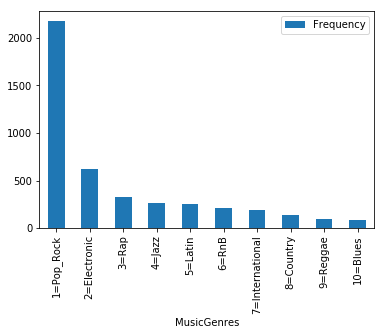

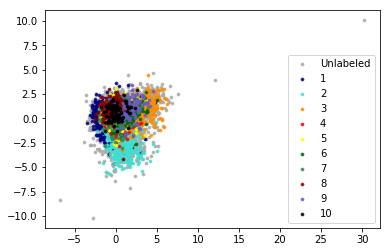

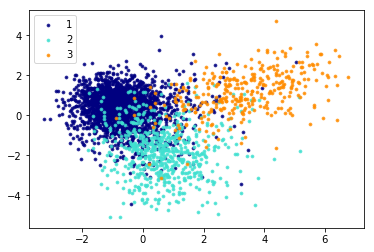

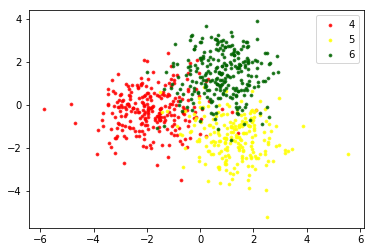

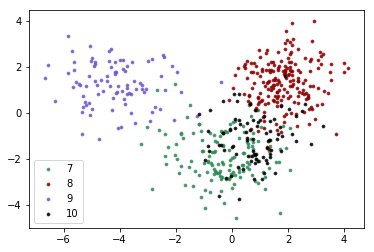

In [4]:


df2=pd.DataFrame(y_train_g)
#class distribution
import matplotlib.pyplot as plt

df = pd.DataFrame({
    "MusicGenres": ['1=Pop_Rock', '2=Electronic', '3=Rap', '4=Jazz', '5=Latin', '6=RnB', '7=International', '8=Country', '9=Reggae', '10=Blues'],
    "Frequency": df2[0].value_counts()
})
df.set_index("MusicGenres",drop=True,inplace=True)
df
df.plot(kind='bar')





scatter2dim([1,2,3,4,5,6,7,8,9,10], lda=True, add_test_data=True)
scatter2dim([1,2,3], lda=True)
scatter2dim([4,5,6], lda=True)
scatter2dim([7,8,9,10], lda=True)



### 2.2. Preprocessing the data


The training data having a bad quality may seriously hamper the accuracy of the classifier that the training yields. Two types of problems with the data may be identified: bad data points called outliers, and bad features.

#### 2.2.1. Finding outliers and Missing values

Outliers refer to data points that dramatically differ from the majority of the training data. If we assume that the training data is generated by some probability distribution, the outliers would be points that seem to be generated by a completely different distribution than most of the data. These kind of points may be in the training data for example due to an error in producing and preprocessing the data. 

Commonly, data points identified as outliers are simply removed from the data. A rationale for this is that the outliers have a relatively large impact on the resulting classifier, but it is unlikely that the test data would contain similar data points, so this impact is harmful.

It can be beneficial to also identify outliers in the test data. This is because there may be no reason the expect that classifiers trained on "usual" data points are applicable on extraordinary points that seem to come from another distribution. In this case, we can identify that the predictions for these points are highly untrustworthy. Moreover, outliers in test data needed to be removed for our clustering approach that uses the test data for training in an unsupervised manner.

We considered multiple methods of outlier removal. The simplest was to simply identify an outlier from that its euclidean distance to a mean is large. For labeled training data, the mean was the class mean, whereas for unlabeled test data the mean for all points was used. Also, we tried a method called Local Outlier Factor (LOF) (Scikit, *Novelty and Outlier Detection*). A very rough descrpiption of it is that it compares the distances of a point *p* to its neighbors to the distances from the neighbors to their respective neighbors, and identifies *p* as an outlier if the former distances are considerably larger than the latter.

A problem with these methods is the high dimensionality of the data. In high-dimensional space, the variance in distances between points tends to be very small, so it is hard to distinguish outliers. Additionally, data points that appear to be outliers for the original data may not be outliers anymore after dimensionality reduction, if the point is unusual only with respect to features that are ignored in the reduced data. Thus, we also applied the above techniques to data whose dimension was reduced using linear discriminant analysis (LDA).

This however raises a further concern: If outliers are only removed after dimensionality reduction, do they affect the dimensionality reduction process itself? We know that LDA tries to minimize in-class variance, so an outlier might cause the LDA to choose a projection where the outlier is near the class mean, but which is overall worse than the respective projection without the outlier. For this reason, we tested one further method for outlier detection, where we identified an outlier based on how much removing a point before projection reduces the in-class variance of the projected data.

We played around with all of these alternatives. In particular, the we have included code for distinguishing outliers in LDA-projected training data by euclidean distance and decrease in in-class variance in the classes *Outlier_remover_lda_distance* and *Outlier_remover_lda_inclass_variance*, respectively. These classes are inteded to be used with the Python command line interpreter. For outlier removal from test data we used the function *outliers_for_unlabeled*, which uses LOF on data whose dimension was reduced using LDA trained on the labeled training data. LOF scores for the data points are presented in figure as output of the last code cell of this section.

We tested different choices of training data outliers by training an LDA classifier on the pruned training data and submitting predictions to Kaggle. Every choice of outliers tried caused a decrease in validation accuracy, so we concluded that the training data does not contain outliers that should be removed for the clustering approach. For outliers in test data, we similarly considered the impact that removing then causes on the performance of clustering. Here, we noticed significant improvement when removing the data points with indices 6631, 7307, 9366, 9580, 9755, 10142, 10509 and 10556.

The first scatter plot figure in the previous section presents visually how unlabeled data (the gray data points) contain much worse outliers than the labeled data (colourful points). However, this visual analysis is somewhat untrustworthy as the projection is made using LDA, which specifically tries to minimized in-class variance whereas it does not care about the unlabeled data.



#### 2.2.2. Analyzing features

For identifying bad features, our first method  was simply looking at the data. We observed that the features indexed 216-220 (inclusive) had each an identical value for all data points. Thus it was completely clear that they should removed in all cases as they provide no information and are thus useless. Moreover, they are harmful, since they make the data matrix and feature covariance matrix singular, causing computational difficulties for ML methods relying on e.g. matrix inversion. Such problems were observed with clustering techniques

Additionally, we identified a number of features which had the same value for most data points. Even these features may cause singularity issues when only handling a subset of data, and making an unluckly choice of data points such that all points have the same value for the feature. Subsets for data points are considered e.g. with cross validation. Even when handling all the data at the same time, the condition number, strongly related to computational feasibility, probably increases significantly due to these features. A listing of them can be found in the function *features_to_take* below.

The second of our methods to remove undesirable features is linear discriminant analysis which we used for dimensionality reduction for the clustering approach. We describe it in section 3.1.3. Finally, we checked that there are no null values in the data.








In [5]:

# Class for finding outliers
# error metric is distance from class centre in the original space or the 9 dim space, depending on if true/false is passed as parameter "transform" to the compute_scores_labelled method (default True)
class Outlier_remover_lda_distance:
    
    # classes as a python list
    def __init__(self, n_components=None, classes=None):
        self.n_components=n_components

        # these shrink when points are removed
        self.scores_labeled = None
        self.raw_scores = None

        self.classes = classes
        if classes is None:
            self.classes = list(range(10))

        # these stay the same when points removed, removals recorded in the index lists
        self.X_all, self.y_train, self.N_train = X_all_g, y_train_g, N_train_g #load_and_scale_data()
        self.X_train = self.X_all[:self.N_train]

        # removals recorded here
        self.removed_indices = []
        self.remaining_indices = list(range(self.N_train))

        if classes:
            self.remaining_indices = [i for i in np.arange(self.N_train) if self.y_train[i] in self.classes]
            
        
    def compute_scores_labeled(self, transform=True):

        lda = LinearDiscriminantAnalysis(n_components=self.n_components)
        lda.fit(self.X_train[self.remaining_indices], self.y_train[self.remaining_indices])

        X = self.X_train[self.remaining_indices]
        y = self.y_train[self.remaining_indices]
        means = lda.means_
        if transform:
            X = lda.transform(self.X_train[self.remaining_indices])
            means = lda.transform(lda.means_)

        means_per_class_label = np.zeros((11,means.shape[1]))
        for i, class_label in enumerate(self.classes):
            means_per_class_label[class_label] = means[i]

        self.scores_labeled = np.array([np.linalg.norm(X[i]-means_per_class_label[y[i]] , ord=2)**2 for i in np.arange(X.shape[0])])

    def delete_worst_point(self, class_label=None):
        worst_score = np.max(self.scores_labeled)
        worst_index_curr = np.argmax(self.scores_labeled)
        worst_index = self.remaining_indices[worst_index_curr]
        if class_label:
            y_curr = self.y_train[self.remaining_indices]
            class_indices_curr = np.where(y_curr == class_label)[0]
            # print(class_indices_curr.shape, class_indices_curr)
            class_scores = self.scores_labeled[class_indices_curr]
            # curr_for_class_index = self.remaining_indices[class__indices]

            worst_score = np.max(class_scores)
            worst_index_class = np.argmax(class_scores)
            # print(worst_index_class)
            worst_index_curr = class_indices_curr[worst_index_class]
            worst_index = self.remaining_indices[worst_index_curr]

            
        print("Worst score", worst_score, "with index", worst_index)
        self.removed_indices.append(worst_index)
        self.remaining_indices.remove(worst_index)
        self.scores_labeled = np.delete(self.scores_labeled, worst_index_curr, axis=0)

    def delete_worst_points(self, amount, class_label=None):
        for i in range(amount):
            self.delete_worst_point(class_label=class_label)

    def print_worst_scores_with_classes(self, amount, class_label=None):
        worst_indices_curr = np.argsort(self.scores_labeled)[::-1]
        worst_indices = np.array(self.remaining_indices)[worst_indices_curr]
        worst_classes = self.y_train[self.remaining_indices][worst_indices_curr]
        worst_scores = self.scores_labeled[worst_indices_curr]

        combined = np.stack((worst_indices, worst_classes, worst_scores),axis=1)
        np.set_printoptions(formatter={'float': lambda x: "{0:0.6g}".format(x)})
        if class_label:
            combined = np.stack([row for row in combined if row[1]==class_label], axis=1).T
        number = np.arange(1,combined.shape[0]+1).reshape((combined.shape[0],1))
        combined = np.concatenate((number, combined), axis=1)
        print(combined[:amount])
        
        

    # def save_scores_labeled(self, filename):
    #     with open(filename, "w") as f:
    #         json.dump(self.scores_labeled.tolist(), f)

    # def load_scores_labeled(self, filename):
    #     with open(filename, "r") as f:
    #         self.scores_labeled = json.load(f)

    def weights_for_test_plotting(self):
        assert not self.scores_labeled is None, "Calculate scores before plotting!"
        return np.array([max(0,score) for score in self.scores_labeled])

    def plot_2d_test(self):
        marker_size = 3
        lda = LinearDiscriminantAnalysis(solver="eigen", n_components=2)
        X = self.X_train[self.remaining_indices]
        y = self.y_train[self.remaining_indices]
        lda.fit(X, y)
        target_names = np.array(["Unlabeled", "1", "2", "3", "4" ,"5", "6", "7" ,"8", "9", "10"])[self.classes]

        X = lda.transform(X)

        # print(lda.covariance_)

        plt.figure()
        colors = np.array(['navy', 'darkorange', "red", "yellow", "darkgreen", "seagreen", "darkred", "slateblue", "black", "turquoise", "darkgray"])[:len(self.classes)]
        lw = 2 

        weights = self.weights_for_test_plotting()

        min_weight = np.min(weights)
        max_weight = np.max(weights)
        radius = (weights-min_weight) / (max_weight-min_weight)
        
        for color, i, target_name in zip(colors, self.classes, target_names):
            plt.scatter(X[y == i, 0], X[y == i, 1], color=color, alpha=.8, lw=lw,
                        label=target_name, s=marker_size)

            plt.scatter(X[y == i, 0], X[y == i, 1], s=1000*radius[y == i], 
                        edgecolors=color, facecolors='none', label='Outlier scores')
        plt.legend(loc='best', shadow=False, scatterpoints=1)
        plt.show(block=False)


# found using the above class
# outlier_indices_clustering = [1842, 4308, 2833, 239, 2762, 2865] 

# example usage
deleter1 = Outlier_remover_lda_distance()
deleter1.compute_scores_labeled()
deleter1.print_worst_scores_with_classes(amount=10)
print()
deleter1.print_worst_scores_with_classes(amount=10, class_label=9)
deleter1.delete_worst_points(3, class_label=None)
deleter1.compute_scores_labeled()
print()
deleter1.print_worst_scores_with_classes(amount=10)
print()
print(deleter1.removed_indices)


[[1 2895 7 223.548]
 [2 2865 2 108.471]
 [3 2762 10 104.327]
 [4 3270 7 86.0469]
 [5 4244 4 81.4746]
 [6 3611 3 79.7997]
 [7 2414 6 76.0647]
 [8 3048 6 75.4937]
 [9 2658 4 75.1961]
 [10 3898 3 74.7856]]

[[1 4056 9 64.7535]
 [2 3975 9 60.8701]
 [3 2267 9 60.0587]
 [4 4330 9 57.4488]
 [5 4024 9 48.138]
 [6 3947 9 44.4759]
 [7 2515 9 43.971]
 [8 2739 9 42.0507]
 [9 4291 9 40.0035]
 [10 3085 9 37.335]]
Worst score 223.54758345327664 with index 2895
Worst score 108.47146782774279 with index 2865
Worst score 104.32744376352646 with index 2762

[[1 4244 4 82.0416]
 [2 3611 3 79.5885]
 [3 3270 7 75.4675]
 [4 3898 3 74.7475]
 [5 3048 6 73.9607]
 [6 2414 6 73.7303]
 [7 3496 5 73.6351]
 [8 2777 2 73.5945]
 [9 2635 3 72.3798]
 [10 2338 2 72.2439]]

[2895, 2865, 2762]


/home/antti/Programs/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


In [6]:
# Class for finding outliers
# A higher outlier score is given to data points whose removal decreases in-class variance more


class Outlier_remover_lda_inclass_variance:
    
    # classes as a python list
    def __init__(self, n_components=9, classes=None):
        self.n_components=n_components

        # these shrink when points are removed
        self.scores_labeled = None
        self.raw_scores = None

        self.classes = classes

        # these stay the same when points removed, removals recorded in the index lists
        self.X_all, self.y_train, self.N_train = X_all_g, y_train_g, N_train_g  #load_and_scale_data()
        self.X_train = self.X_all[:self.N_train]

        # removals recorded here
        self.removed_indices = []
        self.remaining_indices = list(range(self.N_train))

        if classes:
            self.remaining_indices = [i for i in np.arange(self.N_train) if self.y_train[i] in self.classes]


    # not actually an eigenvalue anymore after removal of covar_centroids
    def eigenvalue(self,eigenvector,covar_centroids, covar_in_class):
        num = np.linalg.norm(eigenvector, ord=2)**2 # eigenvector @ eigenvector.T    # eigenvector @ covar_centroids @ eigenvector.T
        den = eigenvector @ covar_in_class @ eigenvector.T
        return num/den

    def eigenvalues(self,lda):
        eigenvectors = lda.scalings_.T[:self.n_components] # by transposing, gets shape n_classes-1,rank
        covar_centroids = np.cov(lda.means_.T) # np.cov wants variables as rows
        covar_in_class = lda.covariance_
        eigenvalues = np.array([self.eigenvalue(eigenvector, covar_centroids, covar_in_class) for eigenvector in eigenvectors])
        return eigenvalues

    def compression_score(self,lda):
        eigenvalues = self.eigenvalues(lda)
        #largest_eigenvalues = np.sort(eigenvalues)[-self.n_components:]
        # print(eigenvalues)
        #print(largest_eigenvalues)
        score = eigenvalues.sum()
        # print("Raw score:", score)
        return score

    def raw_to_scaled_scores(self,raw_scores):
        scaled_scores = []
        for i_curr in range(len(self.remaining_indices)):
            own_score = raw_scores[i_curr]
            y = self.y_train[self.remaining_indices]
            indices = np.array([i for i in np.arange(y.shape[0]) if y[i]==y[i_curr] and not i == i_curr])
            class_scores_others = raw_scores[indices]
            average_others = np.mean(class_scores_others)
            scaled_score = (own_score-average_others)/average_others
            scaled_scores.append(scaled_score)
        return np.array(scaled_scores)
        
    def compute_scores_labeled(self):

        raw_scores = []
        for i_curr in range(len(self.remaining_indices)):
            X_temp = np.delete(self.X_train[self.remaining_indices], i_curr, axis=0)#self.X_train[np.arange(self.N_train) != i_point, :]
            #print(X_temp)
            #print(X_temp.shape)
            y_temp = np.delete(self.y_train[self.remaining_indices], i_curr, axis=0) # self.y_train[np.arange(self.N_train) != i_point]
            #print(y_temp.shape)
            lda = LinearDiscriminantAnalysis(solver="eigen", n_components=self.n_components, store_covariance=True)
            lda.fit(X_temp, y_temp)
            raw_scores.append(self.compression_score(lda))
        
        self.raw_scores = np.array(raw_scores)    

        self.scores_labeled = self.raw_to_scaled_scores(self.raw_scores)
        # print("Scores:")
        # print(self.scores_labeled)
        # return self.scores_labeled

    def delete_worst_point(self, class_label=None):
        worst_score = np.max(self.scores_labeled)
        worst_index_curr = np.argmax(self.scores_labeled)
        worst_index = self.remaining_indices[worst_index_curr]
        if class_label:
            y_curr = self.y_train[self.remaining_indices]
            class_indices_curr = np.where(y_curr == class_label)[0]
            # print(class_indices_curr.shape, class_indices_curr)
            class_scores = self.scores_labeled[class_indices_curr]
            # curr_for_class_index = self.remaining_indices[class__indices]

            worst_score = np.max(class_scores)
            worst_index_class = np.argmax(class_scores)
            # print(worst_index_class)
            worst_index_curr = class_indices_curr[worst_index_class]
            worst_index = self.remaining_indices[worst_index_curr]

            
        print("Worst score", worst_score, "with index", worst_index)
        self.removed_indices.append(worst_index)
        self.remaining_indices.remove(worst_index)
        self.scores_labeled = np.delete(self.scores_labeled, worst_index_curr, axis=0)

    def delete_worst_points(self, amount, class_label=None):
        for i in range(amount):
            self.delete_worst_point(class_label=class_label)

    def print_worst_scores_with_classes(self, amount, class_label=None):
        worst_indices_curr = np.argsort(self.scores_labeled)[::-1]
        worst_classes = self.y_train[self.remaining_indices][worst_indices_curr]
        worst_scores = self.scores_labeled[worst_indices_curr]

        combined = np.stack((worst_classes, worst_scores),axis=1)
        np.set_printoptions(formatter={'float': lambda x: "{0:0.6g}".format(x)})
        if class_label:
            combined = np.stack([row for row in combined if row[0]==class_label], axis=1).T
        number = np.arange(1,combined.shape[0]+1).reshape((combined.shape[0],1))
        combined = np.concatenate((number, combined), axis=1)
        print(combined[:amount])
        
        
    def weights_for_test_plotting(self):
        assert not self.scores_labeled is None, "Calculate scores before plotting!"
        return np.array([max(0,score) for score in self.scores_labeled])

    def plot_2d_test(self):
        marker_size = 3
        lda = LinearDiscriminantAnalysis(solver="eigen", n_components=2)
        X = self.X_train[self.remaining_indices]
        y = self.y_train[self.remaining_indices]
        lda.fit(X, y)
        target_names = np.array(["Unlabeled", "1", "2", "3", "4" ,"5", "6", "7" ,"8", "9", "10"])[self.classes]

        X = lda.transform(X)

        # print(lda.covariance_)

        plt.figure()
        colors = np.array(['navy', 'darkorange', "red", "yellow", "darkgreen", "seagreen", "darkred", "slateblue", "black", "turquoise", "darkgray"])[:len(self.classes)]
        lw = 2 

        weights = self.weights_for_test_plotting()

        min_weight = np.min(weights)
        max_weight = np.max(weights)
        radius = (weights-min_weight) / (max_weight-min_weight)
        
        for color, i, target_name in zip(colors, self.classes, target_names):
            plt.scatter(X[y == i, 0], X[y == i, 1], color=color, alpha=.8, lw=lw,
                        label=target_name, s=marker_size)

            plt.scatter(X[y == i, 0], X[y == i, 1], s=1000*radius[y == i], 
                        edgecolors=color, facecolors='none', label='Outlier scores')
        plt.legend(loc='best', shadow=False, scatterpoints=1)
        plt.show(block=False)



    
# found using the above class
# outlier_indices_clustering_too_many = [2393, 3880, 3581, 4291, 3181, 4039, 3332, 59, 2921, 2469, 1763, 1086, 1230, 749, 284, 1543, 1404, 1393, 2049, 187, 1136, 978, 500, 2253, 2581, 4308, 3411, 4327, 3382, 3097, 3647, 3291, 2434, 3202, 3576, 4066, 2197, 3708, 3665, 3799, 3461, 2460, 4145, 3004, 2436, 3322, 4149, 3286, 4144, 3753, 3506, 2895, 2352, 2620, 3091, 2810, 3155, 3421]

# outlier_indices_clustering = [59, 1763, 3880, 3202, 2921, 4149, 2393, 3581, 4291]


# example usage
deleter2 = Outlier_remover_lda_distance()
deleter2.compute_scores_labeled()
deleter2.print_worst_scores_with_classes(amount=10)
print()
deleter2.print_worst_scores_with_classes(amount=10, class_label=9)
print()
deleter2.delete_worst_points(3, class_label=None)
deleter2.compute_scores_labeled()
print()
deleter2.print_worst_scores_with_classes(amount=10)
print()
print(deleter2.removed_indices)







[[1 2895 7 223.548]
 [2 2865 2 108.471]
 [3 2762 10 104.327]
 [4 3270 7 86.0469]
 [5 4244 4 81.4746]
 [6 3611 3 79.7997]
 [7 2414 6 76.0647]
 [8 3048 6 75.4937]
 [9 2658 4 75.1961]
 [10 3898 3 74.7856]]

[[1 4056 9 64.7535]
 [2 3975 9 60.8701]
 [3 2267 9 60.0587]
 [4 4330 9 57.4488]
 [5 4024 9 48.138]
 [6 3947 9 44.4759]
 [7 2515 9 43.971]
 [8 2739 9 42.0507]
 [9 4291 9 40.0035]
 [10 3085 9 37.335]]

Worst score 223.54758345327664 with index 2895
Worst score 108.47146782774279 with index 2865
Worst score 104.32744376352646 with index 2762

[[1 4244 4 82.0416]
 [2 3611 3 79.5885]
 [3 3270 7 75.4675]
 [4 3898 3 74.7475]
 [5 3048 6 73.9607]
 [6 2414 6 73.7303]
 [7 3496 5 73.6351]
 [8 2777 2 73.5945]
 [9 2635 3 72.3798]
 [10 2338 2 72.2439]]

[2895, 2865, 2762]


/home/antti/Programs/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


/home/antti/Programs/anaconda3/envs/python36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


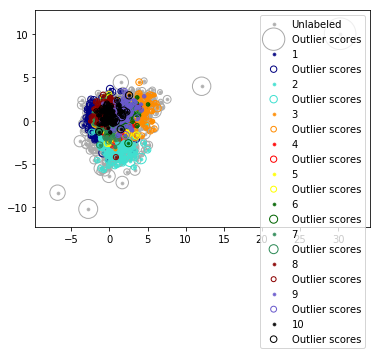

[[9580 12.7277 0]
 [6631 5.17375 0]
 [9366 4.93349 0]
 [9755 3.73108 0]
 [10509 3.71295 0]
 [10142 3.54545 0]
 [10556 2.95422 0]
 [9293 2.92041 0]
 [7307 2.90158 0]
 [2895 2.81961 7]
 [8672 2.78865 0]
 [10902 2.77646 0]
 [6573 2.6709 0]
 [10085 2.58389 0]
 [2414 2.45226 6]
 [5802 2.42343 0]
 [8420 2.40445 0]
 [9915 2.37846 0]
 [6084 2.36188 0]
 [3270 2.36055 7]
 [8750 2.27694 0]
 [10063 2.2461 0]
 [3411 2.23035 2]
 [2865 2.21862 2]
 [10632 2.21641 0]
 [4292 2.2054 7]
 [10660 2.18738 0]
 [10879 2.1656 0]
 [9269 2.16252 0]
 [4788 2.14873 0]
 [9109 2.13363 0]
 [8324 2.12847 0]
 [4979 2.12803 0]
 [6578 2.12019 0]
 [10176 2.10677 0]
 [8702 2.07771 0]
 [7268 2.06597 0]
 [10456 2.04385 0]
 [4668 2.03334 0]
 [9582 2.02671 0]
 [8287 2.02303 0]
 [9657 2.01983 0]
 [10841 2.00116 0]
 [6363 1.99675 0]
 [10608 1.99373 0]
 [10465 1.99254 0]
 [9759 1.99084 0]
 [7079 1.99005 0]
 [10464 1.98014 0]
 [7560 1.96766 0]
 [6023 1.9651 0]
 [2777 1.95592 2]
 [10569 1.95447 0]
 [6856 1.95413 0]
 [4618 1.94612 0]

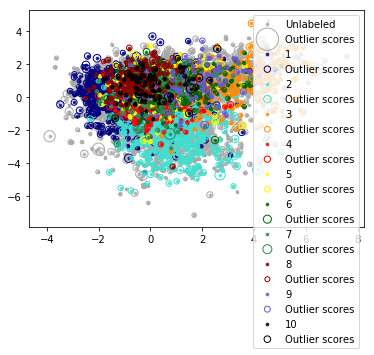

In [7]:
def outliers_for_unlabeled():
    # load data
    X_all, y_train, N_train = X_all_g, y_train_g, N_train_g # load_and_scale_data()
    X_train = X_all[:N_train]
    y_all = np.concatenate((y_train, np.zeros(X_all.shape[0]-N_train)))


    # train dim reducer on train data, transform all data
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    X_all = lda.transform(X_all)
    X_train = X_all[:N_train]


    lof = LocalOutlierFactor(n_neighbors=20)
    lof.fit(X_all)
    scores = -lof.negative_outlier_factor_

    scatter2dim([1,2,3,4,5,6,7,8,9,10], lda=True, add_test_data=True, weights=scores, remove_test_outliers=False)


    worst_indices = np.argsort(scores)[::-1]
    worst_scores = scores[worst_indices]
    worst_classes = y_all[worst_indices]

    combined = np.stack((worst_indices, worst_scores, worst_classes),axis=1)
    np.set_printoptions(formatter={'float': lambda x: "{0:0.6g}".format(x)})
    print(combined[:100])
    
    return scores


scores = outliers_for_unlabeled()

# after outliers removed:

scatter2dim([1,2,3,4,5,6,7,8,9,10], lda=True, add_test_data=True, weights=scores, remove_test_outliers=True)

## 3. Methods and experiments


### 3.1. Overview of the ML methods used

#### 3.1.1. Logistic regression

Logistic regression is a supervised machine learning method for training binary classifiers [jung_machine]. The predictor $h$ is based on a linear map $h(x) = \mathbf{w}^T\mathbf{x}$, for which the training process finds the optimal weight vector $\mathbf{w}$. The predicted label $\hat{y}_i \in \{-1, 1 \}$ is decide by the rule $\hat{y}_i = 1$ if $h(\mathbf{x}) \geq 0$ and $\hat{y}_i = -1$ if $h(x) < 0$. Loss is measured by the function $\epsilon(w \mid X) = (1/N) \sum_{i=1}^{N} \log(1+ \exp(-y_i \mathbf{w}^T \mathbf{x}))$. The optimal weight vector can be found using e.g. gradient descent.

Multiclass classification can be achieved e.g. by the one-vs-all method. There for every class a binary classifier is trained that distinguishes between points of that class and all the other classes. The final label is obtained by comparing the values of $h(x)=\mathbf{w}^T \mathbf{x}$ from the different binary classifiers, and choosing the label that correspond to the highest value (i.e. for each binary classifierlabel 1 corresponds to the class that is being distinguished and -1 to all the others).

#### 3.1.2. Gaussian Mixture Model Fuzzy Clustering

In our work we use as an unsupervised method fuzzy clustering based on Gaussian Mixture Models (GMMs) [jung_machine]. Roughly speaking, gaussian mixtures are probability distributions that consist of preset number of individual gaussian distributions with different parameters, where each individual distribution is equated to a cluster. The goal of the method is to learn the Gaussian Mixture that best explains the data. This is done via an iteration process which alternates between updating the distribution parameters and the probabilities for each data point to belong to each cluster/gaussian. The iteration finds a local optimum that is not guaranteed to be globally optimal.

#### 3.1.3. Linear discriminant analysis

Linear discriminant analysis (LDA) is a supervised learning method for training a classifier and for dimensionality reduction, both purposes of which we also make use of (Scikit, *Linear and Quadratic Discriminant Analysis*). Like GMM fuzzy clustering, LDA is also based on finding gaussian distributions which best explain the data. A key difference to GMM clustering is that the class labels are known beforehand, which allows us to estimate the parameters of the gaussians via closed-from formulas. Also in LDA, the covariance matrices are the same for the gaussians for each class. (Allowing an unique covariance for each class leads to a somewhat more general method, quadratic discriminant analysis.)

Unlabeled data points are then classified according to which gaussian is most likely to have been produced the data point. This leads to linear decision surfaces.

A method for dimensionality reduction is obtained as follows: First, since the covariances are equal for all the gaussians, we can perform a linear change of coordinates such that the covariance matrix becomes an identity matrix in the resulting space. Due to the covariance being the idenity, we can classify points based on euclidean distance from the class centres. This however can be performed equally well if we project the data onto a hyperplane that is spanned by the class centres. These linear mappings together yield the linear transformation for reducing dimensionality of the data. This derivation also explains the fact that the maximum number of dimensions after projection for LDA is the number of classes minus one.

An alternative view of LDA (and a side-effect of the above) is that it maximizes the ratio between variance of the class centres to in-class variance, thus finding a linear projection that separates the classes as well as possible from one another. An exposition from this viewpoint is given in (Tharwat et al., 2017).

#### 3.1.4. Neural Network: A multilayer Perceptron

Neural networks have the ability to model data with high volatility and volume and with complex relations.  For this purpose we tried different architecture of multilayer perceptron is suitable for classification prediction problems and particularly when we are dealing with large datasets. For multilayer perceptron we imported Keras package from Theano neural network library, where we used sequential model configured with varying number of hidden layers, drop out rates and nodes. Here we had:
Neural network configuration: epoches=50, batch_size=394, tanh activation function, and 3 hidden layers, training time of 30 seconds. 

### 3.2. Combined approach

Our intention was to combine the unsupervised and supervised methods reviewed above to obtain an semi-supervised learning method which we hypothesized would yield the best results. After preprocessing both the training and testing data, as detailed in section *WHAT*, we use unsupervised fuzzy clustering based on GMMs. The goal is to obtain clusterings, where the clusters correspond well to classes/genres. As output we obtain a probability matrix *P(i_point, i_class)*, where there is a cell for each data point - class pair telling the probability that the data point belongs to the class. 

Our plan was to then feed these probabilities as input for our two supervised ML methods, logistic regression and neural networks. One possiblity is to consider the probabilities for data point *p* for belonging to the classes as additional features of point *p*, and then proceed with usual supervised classification using either the one-vs-all or one-vs-one method. Another possibility would be to decide to classify points only to the *n* classes that are most likely correct based on clustering, which would entail training supervised classifiers for all combinations of *n* classes. We intended to only try *n=2*, in which case we would only need to train classifiers that distinguish between two classes.

This method of combining unsupervised fuzzy clustering to supervised learning is from the article (Poria et al., 2013). The main differences between our approaches and that of the article are that the article uses fuzzy c-means clustering as the clustering method instead of GMM, and uses SVMs for the supervised learning. It tried other methods as well, but those were the ones they obtained the best results with. They managed to obtain an excellent prediction accuracy of 97.10%.

However, we did not manage to replicate those results. The main obstacle encountered was that we were not able to find good clusterings via GMMs. Thus, we did not see the incentive to try a combined approach, so we settled with trying the methods separately.





In [8]:

# different small utility functions

# prints a csv file that satisfies the submission format for the accuracy competition
# input: a numpy array of predicted labels
def write_submission_file_accuracy(y_predicted, filename="solution_accuracy.csv"):
    df_predicted_validation_labels = pd.DataFrame(data=y_predicted, columns = ["Sample_label"])
    df_predicted_validation_labels.index.name = "Sample_id"
    df_predicted_validation_labels.index += 1

    #df_predicted_validation_labels.to_csv(filename)

# prints a csv file that satisfies the submission format for the logloss competition
# input: a numpy array of predicted labels
def write_submission_file_logloss(likelihood_matrix, filename="solution_logloss.csv"):
    column_names = ["Class_"+str(label) for label in range(1,11)]
    df_likelihood_matrix = pd.DataFrame(data=likelihood_matrix, columns = column_names)
    df_likelihood_matrix.index.name = "Sample_id"
    df_likelihood_matrix.index += 1

    #df_likelihood_matrix.to_csv(filename)

# transforms a shape (Nx10) likelihood matrix into a shape (N,) vector of predictions
def likelihoods_to_predicted_labels(likelihood_matrix):
    return np.array([np.argmax(likelihoods_per_point)+1 for likelihoods_per_point in likelihood_matrix])

# returns the percentage of failed predictions
# y_pred and y_real should have shape (N_samples, 1)
# weights means weighting according to class frequencies
def loss_accuracy(y_pred, y_real, weighted=False):
    weights = np.ones((y_real.shape[0],))
    if weighted:
        class_to_frequency = class_weights(y_real)
        weights = np.array([1/class_to_frequency[y-1] for y in y_real])
    accuracy = np.average(np.array([1 if a == b else 0 for (a,b) in zip(y_pred,y_real)]), weights=weights)
    loss = 1-accuracy
    return loss

# note that y_pred has shape (N_samples,N_labels) while y_real has shape (N_samples,1)
# weights means weighting according to class frequencies
def loss_logloss(y_pred, y_real, weighted=False):
    weights = None
    if weighted:
        class_to_frequency = class_weights(y_real)
        weights = np.array([1/class_to_frequency[y-1] for y in y_real])
    loss = sklearn.metrics.log_loss(y_real, y_pred, sample_weight=weights, labels=[1,2,3,4,5,6,7,8,9,10])
    return loss

# array which tells for every class how many times it occurs in the training labels
# note that class labels start from 1 while class indices start from 0!
def class_weights(y):
    unique, counts = np.unique(y, return_counts=True)
    n_classes = 10
    class_weights = np.zeros(n_classes)
    for classNumber, count in zip(unique, counts):
            class_weights[classNumber-1] = count
    return class_weights

# finalizes probability matrix for submission to the logloss competition
# adds clipping and makees it so that outliers get an equal probability for every genre
def finalize_logloss_output(probabilities, clip=0.01):
    as_list = probabilities.tolist()

    def outliers(i_point, row):
        outliers_in_test_data = [9580, 6631, 9366, 9755, 10509, 10142, 10556, 7307]
        if i_point in outliers_in_test_data:
            return [1/len(row)]*len(row)
        return row
        
    def mapping(elem):
        ret = min(elem, 1-clip)
        ret = max(ret, clip)
        return ret

    outliers_handled = [ outliers(i_point, row) for i_point, row in enumerate(as_list)]
    
    ret = [ [mapping(element) for element in row] for row in outliers_handled]

    return np.array(ret)


In [9]:
# path1="../data/train_data.csv"
# path2="../data/train_labels.csv"

# df_train_data=pd.read_csv(path1,delimiter =None, header=None, index_col=False)
# df_train_labels=pd.read_csv(path2,delimiter =None, header=None, index_col=False)

 
# X_train = X_train_g # np.array(df_train_data.values)
# y_trainn = y_train_g # np.array(df_train_labels.values).ravel()
# print(y_trainn)

def get_nn_clf(X_train, y_trainn):
         
    # in order to fix the dimension                 
    def get_labels(X):
        N=X.shape[0]
        y = np.zeros((N,1))
        for i in range (N):
            y[i]=X[i]
        #raise NotImplementedError()
        return y       




    y_train1=get_labels(y_trainn)
    # print(y_train1)
    # print(np.array(df_train_labels.values))

    from keras.utils import to_categorical
    #y_binary
    y_train = to_categorical(y_train1)[:,1:]

    #Split to test and training with 0.20 ratio
    from sklearn.model_selection import train_test_split  
    X_train, X_test, y_train, y_test = train_test_split(X_train,y_train, test_size=0.20, random_state=0 )


   

    #Part2 : weighted sum - activation function
    #Part3 : Decide to pass a signal or not to pass a signal
    import keras
    from keras.models import Sequential
    from keras.layers import Dense

    #Initialising the ANN
    classifier4 = Sequential()

    #Adding the input layer and the first hidden layers
    classifier4.add(Dense(output_dim=32, init='uniform', activation ='relu', input_dim=260))

    #Adding the 2nd hidden layer
    classifier4.add(Dense(output_dim=11, init='uniform', activation ='relu' ))

    #Add the output layer
    classifier4.add(Dense(output_dim=10, init='uniform', activation ='sigmoid' ))

    #Compiling the ANN
    classifier4.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
    #Fitting the ANN to the Training set

    classifier4.fit(X_train, y_train, batch_size=349, nb_epoch=50)

    #Making the predictions and evaluating the model
    # evaluate the model
    scores = classifier4.evaluate(X_train, y_train)
    print("\n%s: %.2f%%" % (classifier4.metrics_names[1], scores[1]*100))

    #Predicting the test set results
    from sklearn.metrics import accuracy_score

    y_pred=classifier4.predict(X_test)
    predicted = np.argmax(y_pred, axis=1)



    #predicted= to_categorical(predicted)

    y_pred2=(y_pred>0.5)
    
    return classifier4


# train nn on all train data
nn_clf = get_nn_clf(X_train_g, y_train_g)

# cross validate
from keras.utils import to_categorical
skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
test_scores = []
for i_train, i_test in skf.split(X_train_g, y_train_g):
    clf = get_nn_clf(X_train_g[i_train], y_train_g[i_train])
    print(X_train_g[i_test].shape, y_train_g[i_test].shape)
    y_train = to_categorical(y_train_g)[:,1:]
    test_scores.append(clf.evaluate(X_train_g[i_test], y_train[i_test])[1])

print("Validation error:", np.average(test_scores))




Using TensorFlow backend.
/home/antti/Programs/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=260, units=32, kernel_initializer="uniform")`
/home/antti/Programs/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=11, kernel_initializer="uniform")`
/home/antti/Programs/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=10, kernel_initializer="uniform")`
/home/antti/Programs/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/50
3490/3490 [==============================] - 0s 77us/step - loss: 2.2932 - acc: 0.4573
Epoch 2/50
3490/3490 [==============================] - 0s 11us/step - loss: 2.2504 - acc: 0.4989
Epoch 3/50
3490/3490 [==============================] - 0s 8us/step - loss: 2.1405 - acc: 0.4989
Epoch 4/50
3490/3490 [==============================] - 0s 8us/step - loss: 1.9588 - acc: 0.4989
Epoch 5/50
3490/3490 [==============================] - 0s 10us/step - loss: 1.7741 - acc: 0.4989
Epoch 6/50
3490/3490 [==============================] - 0s 11us/step - loss: 1.6457 - acc: 0.4989
Epoch 7/50
3490/3490 [==============================] - 0s 8us/step - loss: 1.5950 - acc: 0.4989
Epoch 8/50
3490/3490 [==============================] - 0s 8us/step - loss: 1.5671 - acc: 0.4989
Epoch 9/50
3490/3490 [==============================] - 0s 10us/step - loss: 1.5477 - acc: 0.4989
Epoch 10/50
3490/3490 [==============================] - 0s 12us/step - loss: 1.5326 - acc: 0.4989
Epoch 11/50
3490/3490 [

2792/2792 [==============================] - 0s 7us/step - loss: 1.4829 - acc: 0.5011
Epoch 14/50
2792/2792 [==============================] - 0s 8us/step - loss: 1.4629 - acc: 0.5011
Epoch 15/50
2792/2792 [==============================] - 0s 7us/step - loss: 1.4447 - acc: 0.5011
Epoch 16/50
2792/2792 [==============================] - 0s 7us/step - loss: 1.4276 - acc: 0.5011
Epoch 17/50
2792/2792 [==============================] - 0s 7us/step - loss: 1.4106 - acc: 0.5011
Epoch 18/50
2792/2792 [==============================] - 0s 7us/step - loss: 1.3950 - acc: 0.5136
Epoch 19/50
2792/2792 [==============================] - 0s 8us/step - loss: 1.3789 - acc: 0.5279
Epoch 20/50
2792/2792 [==============================] - 0s 7us/step - loss: 1.3639 - acc: 0.5326
Epoch 21/50
2792/2792 [==============================] - 0s 7us/step - loss: 1.3486 - acc: 0.5358
Epoch 22/50
2792/2792 [==============================] - 0s 7us/step - loss: 1.3338 - acc: 0.5372
Epoch 23/50
2792/2792 [=========

In [10]:
# write a submission file for the competition for NN results



y_pred_submission=nn_clf.predict(X_test_g)
predicted_submission = np.argmax(y_pred_submission, axis=1)+1

y_train_categorical = to_categorical(y_train_g)[:,1:]
print("Training error:", nn_clf.evaluate(X_train_g, y_train_categorical)[1])

print(y_pred_submission)
y_pred_finalized = finalize_logloss_output(y_pred_submission)
print(y_pred_finalized)
print(y_pred_finalized.shape)
print(predicted_submission)
print(predicted_submission.shape)

write_submission_file_accuracy(predicted_submission, "nn_results_accuracy.csv")
write_submission_file_logloss(y_pred_finalized, "nn_results_logloss.csv")

4363/4363 [==============================] - 0s 17us/step
Training error: 0.6740774696036651
[[0.0372843 0.0645425 0.129138 ... 0.000232729 0.0294085 0.00104217]
 [0.113295 0.141891 0.470974 ... 0.00924347 0.227681 0.0168439]
 [0.250612 0.0004183 8.12862e-05 ... 0.0342406 5.13731e-05 0.00185677]
 ...
 [0.251896 0.00950634 0.000294961 ... 0.0015649 0.000125477 0.00219388]
 [0.00355256 0.0216815 0.102853 ... 3.37766e-08 0.00111919 1.05516e-06]
 [0.260945 0.00676414 0.000769866 ... 0.0478514 0.000908371 0.0135761]]
[[0.0372843 0.0645425 0.129138 ... 0.01 0.0294085 0.01]
 [0.113295 0.141891 0.470974 ... 0.01 0.227681 0.0168439]
 [0.250612 0.01 0.01 ... 0.0342406 0.01 0.01]
 ...
 [0.251896 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.0216815 0.102853 ... 0.01 0.01 0.01]
 [0.260945 0.01 0.01 ... 0.0478514 0.01 0.0135761]]
(6544, 10)
[3 3 1 ... 1 3 1]
(6544,)


In [11]:
def naive_lr_classifier(X_train, y_train):
    # Could use option class_weight = "balanced". No sure what it does, worsens results for test(), almost identical result when training with all of the training data
    classifier = LogisticRegression(random_state=0, solver='lbfgs',
                                    multi_class='ovr').fit(X_train, y_train)
    return classifier
   
# test by dividing labeled training data into training and validation data (50%-50%)
def test(seed):
    # train for part of the training data

    np.random.seed(seed)

    X,y = X_train_g, y_train_g 
    N = X.shape[0]

    # shuffledIndices = np.array(range(N))
    # np.random.shuffle(shuffledIndices)

    # splitPosition = round(3*N/4)
    # train_indices = shuffledIndices[:splitPosition]
    # test_indices = shuffledIndices[splitPosition:]
    
    skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
    test_scores = []
    for i_train, i_test in skf.split(X, y):
        clf = naive_lr_classifier(X[i_train], y[i_train])
        test_scores.append(clf.score(X[i_test], y[i_test]))

    print("Validation error:", np.average(test_scores))


print("Validating with random splits, reserving 1/4 of data for validation:")
test(0)


lr_clf = naive_lr_classifier(X_train_g, y_train_g)

print("Training accuracy for submission classifier:", lr_clf.score(X_train_g, y_train_g))


write_submission_file_accuracy(lr_clf.predict(X_test_g), "lr_results_accuracy.csv")
write_submission_file_logloss(finalize_logloss_output(lr_clf.predict_proba(X_test_g)), "lr_results_logloss.csv")


Validating with random splits, reserving 1/4 of data for validation:
Validation error: 0.6438007766821491
Training accuracy for submission classifier: 0.7616319046527619


In [12]:
def lda_classify_accuracy(filename_prefix="results_lda"):

    X_all, y_train, N_train = X_all_g, y_train_g, N_train_g  # load_and_scale_data()
    X_train = X_all[:N_train]
    X_test = X_all[N_train:]

    # points_to_skip = outlier_indices_clustering
    # points_to_take = np.array([i for i in range(N_train) if not i in points_to_skip]) 

    # X_train = X_train[points_to_take]
    # y_train = y_train[points_to_take]

    

    lda = LinearDiscriminantAnalysis()

    lda.fit(X_train, y_train)

    print("Accuracy with training data:", lda.score(X_train, y_train))

    prob_predicted_train = lda.predict_proba(X_train)
    print("Logloss with training data:", loss_logloss(prob_predicted_train, y_train))

    y_predicted = lda.predict(X_test)
    prob_predicted = lda.predict_proba(X_test)

    write_submission_file_accuracy(y_predicted, filename=filename_prefix+"_accuracy.csv")
    write_submission_file_logloss(finalize_logloss_output(prob_predicted), filename=filename_prefix+"_logloss.csv")
    
    # cross validate
    skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
    test_scores = []
    for i_train, i_test in skf.split(X_train, y_train):
        lda = LinearDiscriminantAnalysis()
        lda.fit(X_train[i_train], y_train[i_train])
        test_scores.append(lda.score(X_train[i_test], y_train[i_test]))

    print("Validation error:", np.average(test_scores))
    
lda_classify_accuracy()

Accuracy with training data: 0.7400870960348385
Logloss with training data: 0.8411390130912851


/home/antti/Programs/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Validation error: 0.646544405771927


In [ ]:

# RUNNING THIS CELL TAKES A FEW MINUTES DUE TO QUITE HEAVY COMPUTATIONS. DON'T PANIC!


# code for searching for good unsupervised GMM clusterings
# intended to be used interactively from the command line interpreter, example use at the end

    

# a wrapper class for sklearn.mixture.GaussianMixture
class Gmm:
    
    def __init__(self, X_all, covariance_type, random_seed=0, file_name=None, n_clusters=10, kmeans=False, weights_init=None, means_init=None, precisions_init=None):
        self.n_clusters = n_clusters
        self.n_classes = 10

        self.X_all = X_all

        self.covariance_type = covariance_type

        self.gmm = None
        if file_name:
            self.load_gmm(file_name)
        else:
            self.train(random_seed, kmeans, weights_init, means_init, precisions_init)

    def get_gmm(self):
        assert (self.gmm), "No GMM found!"
        return self.gmm


    def train(self, random_seed=0, kmeans=False, weights_init=None, means_init=None, precisions_init=None):

        initialGuess = "kmeans" if kmeans else "random"
        self.gmm = GaussianMixture(n_components=self.n_clusters, 
                                   covariance_type=self.covariance_type, 
                                   tol=0.001,
                                   max_iter=1000,
                                   n_init=1, 
                                   init_params=initialGuess,
                                   weights_init=weights_init,
                                   means_init=means_init,
                                   precisions_init=precisions_init,
                                   random_state=random_seed,
                                   verbose=0)
        self.gmm.fit(self.X_all)

    def save_gmm(self, file_name):
        with open(file_name, "wb") as output_file:
            pickle.dump(self.gmm, output_file)

    def load_gmm(self, file_name):
        with open(file_name, "rb") as input_file:
            self.gmm = pickle.load(input_file)
        assert (self.gmm.get_params()["n_components"]==self.n_clusters), "Number of clusters differs between parameter of this class and loaded model"

    def get_class_confidence_per_cluster(self, X_train, y_train, unscaled=False):
        # want to give each class an equal amount of votes, so count class weights for that
        class_weights_array = class_weights(y_train)

        # determine class for each cluster by voting, data points split their 1/class_weight vote among classes according to their probabilities of belonging
        belongings_train = self.likelihood_matrix(X_train)
        votes_per_cluster = belongings_train.T
        # print("Votes per cluster:", votes_per_cluster.shape, votes_per_cluster)
        class_confidence_per_cluster = np.zeros((self.n_clusters, self.n_classes))
        # print("class_confidence_per_cluster:", class_confidence_per_cluster.shape, class_confidence_per_cluster)
        for i_cluster, votes in enumerate(votes_per_cluster):
            for i_data_point, value in enumerate(votes):
                i_class = y_train[i_data_point]-1
                class_confidence_per_cluster[i_cluster][i_class] += value/class_weights_array[i_class]

        # print("class confidence before scaling:", class_confidence_per_cluster)

        if unscaled:
            return class_confidence_per_cluster

        # scale so that values sum to 1, representing probabilities
        for iCluster, cluster in enumerate(class_confidence_per_cluster):
            class_confidence_per_cluster[iCluster] /= cluster.sum()
        return class_confidence_per_cluster

    def get_class_per_cluster(self, X_train, y_train):
        class_per_cluster = np.zeros(self.n_classes)
        class_confidence_per_cluster = self.get_class_confidence_per_cluster(X_train, y_train)
        for i_cluster in range(class_per_cluster.shape[0]):
            class_per_cluster[i_cluster] = np.argmax(class_confidence_per_cluster[i_cluster])+1
        # print("Class per cluster:", class_per_cluster)
        return class_per_cluster

    # Loss for the trained model. Portion of predicted training labels that went wrong.
    def loss_accuracy(self, X, y_true, weighted=False):
        y_pred = self.get_gmm().predict(X)+1

        # class_per_cluster = self.get_class_per_cluster()
        # y_pred = np.array([class_per_cluster[cluster] for cluster in self.get_gmm().predict(X)])
        return loss_accuracy(y_pred, y_true, weighted=weighted)

    # def train_loss_accuracy(self, weighted=False):
    #     return self.loss_accuracy(self.X_train, self.y_train, weighted=weighted)

    # def test_loss_accuracy(self, weighted=False):
    #     return self.loss_accuracy(self.X_test, self.y_test, weighted=weighted)

    def loss_logloss(self, X, y_real, weighted=False):
        return loss_logloss(self.likelihood_matrix(X), y_real, weighted=weighted)

    # def train_loss_logloss(self, weighted=False):
    #     return self.loss_logloss(self.likelihood_matrix_train(), self.y_train, weighted=weighted)

    # def test_loss_logloss(self, weighted=False):
    #     return self.loss_logloss(self.likelihood_matrix_test(), self.y_test, weighted=weighted)

    def likelihood_matrix(self, X):
        return self.get_gmm().predict_proba(X)
    

def single_class_gmm_params(covariance_type, X):
    gmm = GaussianMixture(n_components=1, 
                               covariance_type=covariance_type, 
                               tol=0.001,
                               max_iter=1000,
                               n_init=1, 
                               init_params="kmeans",
                               random_state=0,
                               verbose=0)

    gmm.fit(X)
    # print(gmm.means_.shape, gmm.precisions_.shape)
    return gmm.means_.reshape(gmm.means_.shape[1:]), gmm.precisions_.reshape(gmm.precisions_.shape[1:])
    


def transform_precisions(precisions_in, input_type, output_type, n_components, n_features):
    ret = None

    if input_type == output_type:
        ret = precisions_in
    elif input_type=="spherical" and output_type=="full":
        ret = []
        for prec in precisions_in:
            new = np.zeros((n_features,n_features))
            np.fill_diagonal(new, prec)
            ret.append(new)
        ret = np.array(ret)
    # print("Transformed precisions:",ret)
    elif input_type=="full" and output_type=="full":
        ret = precisions_in
    elif input_type=="diag" and output_type=="full":
        ret = []
        for prec in precisions_in:
            ret.append(np.diag(prec))
        ret = np.array(ret)
    elif input_type=="tied" and output_type=="full":
        ret = []
        for i in range(n_components):
            ret.append(precisions_in)
        ret = np.array(ret)
    elif input_type=="spherical" and output_type=="diag":
        ret = []
        for prec in precisions_in:
            ret.append(np.array([prec]*n_features))
        ret = np.array(ret)
    else:
        assert False, "Precision conversion from "+input_type+" to "+output_type+" not implemented."
        
    return ret



# class representing the state of a single search for good clusterings
class Search_data():

    def __init__(self, name, X_labeled, y_labeled, i_train, i_test):

        self.name = name
        
        self.X_labeled = X_labeled
        self.y_labeled = y_labeled
        
        self.X_train = X_labeled[i_train]
        self.y_train = y_labeled[i_train]

        self.X_test = X_labeled[i_test]
        self.y_test = y_labeled[i_test]

        self.next_seeds = {} # for each n_splits

        self.best_loss_accuracy = 1
        self.best_loss_accuracy_weighted = 1
        self.best_loss_logloss = np.Infinity
        self.best_loss_logloss_weighted = np.Infinity 


        self.best_gmm_accuracy = None
        self.best_gmm_accuracy_weighted = None
        self.best_gmm_logloss = None
        self.best_gmm_logloss_weighted = None

        self.whole_training_data_tried = False

    def evaluate_gmm(self, gmm):
        loss_accuracy = gmm.loss_accuracy(self.X_train, self.y_train, weighted=False)
        loss_accuracy_weighted = gmm.loss_accuracy(self.X_train, self.y_train, weighted=True)
        loss_logloss = gmm.loss_logloss(self.X_train, self.y_train, weighted=False)
        loss_logloss_weighted = gmm.loss_logloss(self.X_train, self.y_train, weighted=True)
        record_types_found = []


        if loss_accuracy < self.best_loss_accuracy:
            self.best_loss_accuracy = loss_accuracy
            self.best_gmm_accuracy = gmm
            record_types_found.append("accuracy")
        if loss_accuracy_weighted < self.best_loss_accuracy_weighted:
            self.best_loss_accuracy_weighted = loss_accuracy_weighted
            self.best_gmm_accuracy_weighted = gmm
            record_types_found.append("accuracy_weighted")
        if loss_logloss < self.best_loss_logloss:
            self.best_loss_logloss = loss_logloss
            self.best_gmm_logloss = gmm
            record_types_found.append("logloss")
        if loss_logloss_weighted < self.best_loss_logloss_weighted:
            self.best_loss_logloss_weighted = loss_logloss_weighted
            self.best_gmm_logloss_weighted = gmm
            record_types_found.append("logloss_weighted")
            
        return record_types_found

    def print_results_for_gmm(self, gmm):
        print("Class per cluster:  ", gmm.get_class_per_cluster(self.X_train, self.y_train))
        
        np.set_printoptions(formatter={'float': lambda x: "{0:2.0f}".format(x)})
        print("Class confidence per cluster")
        print(gmm.get_class_confidence_per_cluster(self.X_train, self.y_train)*100)
        
        np.set_printoptions(formatter={'float': lambda x: "{0:0.6g}".format(x)})

        print("Unweighted losses:")
        print("Train loss accuracy:", gmm.loss_accuracy(self.X_train, self.y_train, weighted=False))
        print("Test loss accuracy:   ", gmm.loss_accuracy(self.X_test, self.y_test, weighted=False))
        print("Train loss logloss: ", gmm.loss_logloss(self.X_train, self.y_train, weighted=False))
        print("Test loss logloss:    ", gmm.loss_logloss(self.X_test, self.y_test, weighted=False))
        print("Weighted:")
        print("Train loss accuracy:", gmm.loss_accuracy(self.X_train, self.y_train, weighted=True))
        print("Test loss accuracy:   ", gmm.loss_accuracy(self.X_test, self.y_test, weighted=True))
        print("Train loss logloss: ", gmm.loss_logloss(self.X_train, self.y_train, weighted=True))
        print("Test loss logloss:    ", gmm.loss_logloss(self.X_test, self.y_test, weighted=True))

        
    # types: "accuracy", "accuracy_weighted", "logloss", "logloss_weighted"
    def print_record(self, record_types):
        print()
        for record_type in record_types:
            print("Record for "+self.name+" with type "+record_type+":")
        for record_type in record_types:
            if record_type == "accuracy":
                self.print_results_for_gmm(self.best_gmm_accuracy)
            elif record_type == "accuracy_weighted":
                self.print_results_for_gmm(self.best_gmm_accuracy_weighted)
            elif record_type == "logloss":
                self.print_results_for_gmm(self.best_gmm_logloss)
            elif record_type == "logloss_weighted":
                self.print_results_for_gmm(self.best_gmm_logloss_weighted)
            break

            

# class representing the overall search procedure (search for good GMM clusterings)
class Clustering_search():

    def __init__(self, reduce_dim=False, cov_types_guess=["tied"], cov_type_clustering="tied", do_pca=True):

        # load scaled data
        self.X_all_with_outliers, self.y_labeled, self.N_labeled, self.X_all = X_all_pg, y_train_g, N_train_g, X_all_outliers_removed_pg # load_and_scale_data()
        self.X_labeled = self.X_all[:self.N_labeled]
        self.X_unlabeled = self.X_all[self.N_labeled:]

        # transformation of data, with LDA if reducing dimensionality, otherwise PCA
        self.reduce_dim = reduce_dim

        self.lda = None
        self.pca = None
        if reduce_dim:
            self.lda = LinearDiscriminantAnalysis()
            self.lda.fit(self.X_labeled, self.y_labeled)
            self.X_all = self.lda.transform(self.X_all)
            self.X_labeled = self.X_all[:self.N_labeled]
            self.X_unlabeled = self.X_all[self.N_labeled:]
            self.X_all_with_outliers = self.lda.transform(self.X_all_with_outliers)
        elif do_pca: # PCA without reducing dimensionality
            self.pca = PCA()
            self.pca.fit(self.X_all)
            self.X_all = self.pca.transform(self.X_all)
            self.X_all_with_outliers = self.pca.transform(self.X_all_with_outliers)

            print("Dimensions after PCA:", self.X_all.shape[1])

            scaler = StandardScaler().fit(self.X_all)
            self.X_all = scaler.transform(self.X_all)
            self.X_labeled = self.X_all[:self.N_labeled]
            self.X_unlabeled = self.X_all[self.N_labeled:]
            self.X_all_with_outliers = scaler.transform(self.X_all_with_outliers)
            
        # set covariance types to be used
        self.cov_types_guess = cov_types_guess
        self.cov_type_clustering = cov_type_clustering

        self.n_classes=10
        self.n_features = self.X_all.shape[1]
        
        # # if not reducing dimensionality, initial guess has to be made using "tied"
        # if not reduce_dim:
        #     self.cov_types_guess = ["tied"]

        # initialize data for actual search
        self.search_actual = Search_data("actual", self.X_labeled, self.y_labeled, np.arange(self.N_labeled), np.arange(self.N_labeled))

        # initialize data for validation searches
        self.searches_validation = []
        skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
        i_search = 1
        for i_train, i_test in skf.split(self.X_labeled, self.y_labeled):
            print("i_train:", i_train.shape[0], "i_test:", i_test.shape[0])
            self.searches_validation.append(Search_data(f"test{i_search}", self.X_labeled, self.y_labeled, i_train, i_test))
            i_search += 1

    def search_for_all(self, max_n_splits, n_times):
        self.search_for_final(max_n_splits, n_times)
        self.search_for_validation(max_n_splits, n_times)

    def search_for_validation(self, max_n_splits, n_times):
        for search_data in self.searches_validation:
            self.progress_search(search_data, max_n_splits, n_times)

    def search_for_final(self, max_n_splits, n_times):
        self.progress_search(self.search_actual, max_n_splits, n_times)


    def progress_search(self, search_data, max_n_splits, n_times):

        if not search_data.whole_training_data_tried:
            for cov_type in self.cov_types_guess:
                self.handle_initial_guess(search_data, np.arange(search_data.X_train.shape[0]), cov_type)
            search_data.whole_training_data_tried = True

        for n_splits in range(2, max_n_splits+1):
            seed = 0
            if n_splits in search_data.next_seeds:
                seed = search_data.next_seeds[n_splits]

            print("Searching for "+search_data.name+f" with n_splits {n_splits} from seed {seed} until {seed+n_times}")
            for i in range(n_times):
                for cov_type in self.cov_types_guess:
                    skf = StratifiedKFold(n_splits=n_splits, random_state=seed, shuffle=True)
                    for i_guess, _ in skf.split(search_data.X_train, search_data.y_train):
                        self.handle_initial_guess(search_data, i_guess, cov_type)
                seed += 1

            search_data.next_seeds[n_splits] = seed


    def handle_initial_guess(self, search_data, i_guess, guess_cov_type):
        # get guess output
        weights, means, precisions = self.get_initial_guess(search_data, i_guess, guess_cov_type)
        # train gmm with initial guess
        gmm = Gmm(covariance_type = self.cov_type_clustering, X_all=self.X_all, weights_init=weights, means_init=means, precisions_init=precisions)

        # get results, and do with them what you need to do
        
        record_types = search_data.evaluate_gmm(gmm)
        if len(record_types) > 0:
            search_data.print_record(record_types)

        # can evaluate validation classifiers for actual search as well
        if search_data.name != self.search_actual.name:
            record_types = self.search_actual.evaluate_gmm(gmm)
            if len(record_types) > 0:
                self.search_actual.print_record(record_types)

        
        
    def get_initial_guess(self, search_data, i_guess, guess_cov_type):

        X_guess = search_data.X_train[i_guess]
        y_guess = search_data.y_train[i_guess]

        guess_indices_for_class = [ np.where(y_guess==label)[0] for label in range(1, 11) ]

        weights_unscaled = class_weights(y_guess)
        weights = weights_unscaled/weights_unscaled.sum() 

        means = None
        precisions = None
        
        if guess_cov_type == "tied":
            lda = LinearDiscriminantAnalysis(store_covariance=True)
            lda.fit(X_guess, y_guess)
            precisions = np.linalg.inv(lda.covariance_)
            means = lda.means_

            
        else:
            means, precisions = zip(*[ single_class_gmm_params(guess_cov_type, X_guess[guess_indices_for_class[i_class]]) for i_class in range(10)])

        # TODO: covariance conversion?
        precisions = transform_precisions(precisions_in=precisions, input_type=guess_cov_type, output_type=self.cov_type_clustering, n_components=self.n_classes, n_features=self.n_features)
        return weights, means, precisions


    def save(self, filename):
        with open(filename, "wb") as output_file:
            pickle.dump(self, output_file)



def load_search(filename):
    with open(filename, "rb") as input_file:
        return pickle.load(input_file)


search = Clustering_search(reduce_dim=True, cov_types_guess=["diag"], cov_type_clustering="full")
search.search_for_validation(5,10)
search.search_for_final(5,10)
    
    
    


i_train: 3486 i_test: 877
i_train: 3489 i_test: 874
i_train: 3490 i_test: 873
i_train: 3493 i_test: 870
i_train: 3494 i_test: 869

Record for test1 with type accuracy:
Record for test1 with type accuracy_weighted:
Record for test1 with type logloss:
Record for test1 with type logloss_weighted:
Class per cluster:   [1 2 3 4 5 6 2 8 9 10]
Class confidence per cluster
[[31  7  2  4 10  6 11 16  1 12]
 [ 6 49  5 10  6  5 10  1  6  2]
 [ 1  3 57  1  5  9  4  1 17  1]
 [ 3  4  1 42  9 10  9  3  2 17]
 [ 4  1  3  4 37 11 20  4  8  8]
 [ 4  4  6  8  7 45  7  6  9  5]
 [ 5 26  9 11 12  5 18  2  8  5]
 [ 5  0  1  2  9  7 13 54  1  8]
 [ 1  2  5  1  4  3  4  0 79  0]
 [ 4  1  1 15  3  2 11  3  2 57]]
Unweighted losses:
Train loss accuracy: 0.3270223752151463
Test loss accuracy:    0.3033067274800456
Train loss logloss:  1.3472707499007779
Test loss logloss:     1.2928551152819516
Weighted:
Train loss accuracy: 0.5047871757846203
Test loss accuracy:    0.4873937373170154
Train loss logloss:  1.988

[[31  6  2  4 10  6 11 16  1 12]
 [ 6 51  5  9  6  4 10  1  5  2]
 [ 1  3 57  1  5  9  4  1 18  1]
 [ 3  4  1 44  9 10  9  3  3 15]
 [ 4  1  2  4 38 10 19  5  8  8]
 [ 4  4  7  7  7 44  8  6  8  6]
 [ 5 24  9 14 10  4 16  1  6 10]
 [ 5  1  0  2  8  7 13 56  1  7]
 [ 1  2  6  1  3  3  5  0 77  1]
 [ 5  1  1 10  6  3 12  3  2 57]]
Unweighted losses:
Train loss accuracy: 0.3236305294522118
Test loss accuracy:    0.3236305294522118
Train loss logloss:  1.3303388353772754
Test loss logloss:     1.3303388353772754
Weighted:
Train loss accuracy: 0.504099976696203
Test loss accuracy:    0.504099976696203
Train loss logloss:  1.9738519975787288
Test loss logloss:     1.9738519975787288

Record for actual with type logloss_weighted:
Class per cluster:   [1 2 3 4 5 6 2 8 9 10]
Class confidence per cluster
[[32  7  2  4 11  6 11 16  1 12]
 [ 6 50  5 10  6  5 10  1  6  2]
 [ 1  3 59  1  5 11  4  1 13  1]
 [ 3  4  1 45  8  9  9  3  2 17]
 [ 4  2  2  4 39 12 18  5  7  8]
 [ 4  4  6  8  7 46  6  6  8 

Train loss accuracy: 0.31583772633509055
Test loss accuracy:    0.31583772633509055
Train loss logloss:  1.3149392256728751
Test loss logloss:     1.3149392256728751
Weighted:
Train loss accuracy: 0.4887007301070574
Test loss accuracy:    0.4887007301070574
Train loss logloss:  1.969900201529746
Test loss logloss:     1.969900201529746

Record for test1 with type logloss_weighted:
Class per cluster:   [1 2 3 4 5 6 2 8 9 10]
Class confidence per cluster
[[31  7  2  4 10  6 11 16  1 12]
 [ 6 50  5 10  6  5 10  1  6  2]
 [ 1  3 60  1  5  9  4  0 14  1]
 [ 3  4  1 44  9 10  9  3  2 16]
 [ 4  2  3  4 38 12 20  4  7  7]
 [ 4  4  6  8  7 45  6  6  9  5]
 [ 5 23  8 12 11  5 16  1  8 12]
 [ 5  0  0  2  9  7 14 53  1  8]
 [ 1  2  6  1  4  4  4  0 77  1]
 [ 4  1  1 12  5  3 10  3  3 58]]
Unweighted losses:
Train loss accuracy: 0.32530120481927716
Test loss accuracy:    0.3044469783352337
Train loss logloss:  1.3355782788553112
Test loss logloss:     1.2708224131516892
Weighted:
Train loss accurac

Class per cluster:   [1 2 3 4 5 6 2 8 9 10]
Class confidence per cluster
[[30  6  2  4 11  6 11 16  1 12]
 [ 6 50  5 11  6  5 10  1  5  2]
 [ 1  3 60  1  4 10  4  1 15  1]
 [ 3  3  1 49  7  8  9  3  2 16]
 [ 4  2  3  4 40  9 20  5  6  7]
 [ 4  4  6  8  8 45  7  5  9  5]
 [ 4 21  9 13  9  4 15  1  8 15]
 [ 5  1  0  2  8  8 14 54  1  7]
 [ 1  1  6  1  4  4  5  0 76  1]
 [ 4  1  2  4  7  4 11  3  2 61]]
Unweighted losses:
Train loss accuracy: 0.3167545267018107
Test loss accuracy:    0.3167545267018107
Train loss logloss:  1.300689051978851
Test loss logloss:     1.300689051978851
Weighted:
Train loss accuracy: 0.4885838424548945
Test loss accuracy:    0.4885838424548945
Train loss logloss:  1.9599667073718483
Test loss logloss:     1.9599667073718483

Record for test2 with type logloss_weighted:
Class per cluster:   [1 2 3 4 5 6 2 8 9 10]
Class confidence per cluster
[[32  6  2  4 10  7 11 16  1 11]
 [ 6 50  5 10  6  5 10  1  5  2]
 [ 1  3 60  1  5  9  4  1 15  1]
 [ 3  4  1 47  6  9  8 

In [ ]:
def produce_output(search, filename_prefix):

    X_all_with_outliers = search.X_all_with_outliers
    X_unlabeled = X_all_with_outliers[search.N_labeled:]


    def output_for_gmm(gmm, name):
        predictions_accuracy = gmm.get_gmm().predict(X_unlabeled)+1
        predictions_proba = gmm.get_gmm().predict_proba(X_unlabeled)

        
        # write csv with no headers or indices, just probabilities
        df = pd.DataFrame(data=predictions_proba, index=None, columns=None)
        # df.to_csv("clustering_results/"+filename_prefix+"_"+name+"_probabilities.csv", header=None)


        predictions_proba = finalize_logloss_output(predictions_proba)
        
        # write csv in submission format for accuracy
        write_submission_file_accuracy(predictions_accuracy, filename="clustering_results/"+filename_prefix+"_"+name+"_submission_accuracy.csv")

        # write csv in submission format for logloss

        write_submission_file_logloss(predictions_proba, filename="clustering_results/"+filename_prefix+"_"+name+"_submission_logloss.csv")

    output_for_gmm(search.search_actual.best_gmm_accuracy, "accuracy")
    output_for_gmm(search.search_actual.best_gmm_accuracy_weighted, "accuracy_weighted")
    output_for_gmm(search.search_actual.best_gmm_logloss, "logloss")
    output_for_gmm(search.search_actual.best_gmm_logloss_weighted, "logloss_weighted") 


produce_output(search, "results_clustering")

search.search_actual.print_results_for_gmm(search.search_actual.best_gmm_accuracy)

for search_data in search.searches_validation:
    search_data.print_results_for_gmm(search_data.best_gmm_accuracy)


## 4. Results

The table below details the results obtained. All numbers except in the last column represent the error metric accuracy, which is defined as the proportion of predictions that are correct (where a prediction for each test data point is a single class label). Training accuracy is the accuracy for predictions made on the training data. We 5-fold cross validated all methods, so cross validation accuracy represents the average validation error. The cross validation was stratified, which implies that the relative frequencies of the labels were in each split as close as possible to the ones in all of the training data. The last two columns represents score obtained for predictions on unlabeled data, for which we do not have the correct labels, but evaluation is performed as a part of a private Kaggle competition. In the last column, the logLoss error metric is used.


| Method | Training accuracy |  Cross validation accuracy  | Kaggle accuracy | Kaggle logLoss | 
| --- | --- | --- | --- | --- |
| Logistic regression | 0.762 | 0.644 | 0.649 | 0.181 |
| LDA | 0.740 | 0.647 | 0.635 | 0.187 |
| GMM clustering | 0.687 | 0.679 | 0.597 | 0.276 |
| Neural networks | 0.679 | 0.596 | 0.637 | 0.248 |





## 5. Discussion/Conclusions

In the results table in the previous section, training accuracy is in all cases higher than cross validation accuracy, as expected. However, the difference is modest, so no method suffers from significant overfitting. 

Based on cross validation on training data, GMM clustering appears to be the most effective method. However, in Kaggle evaluation it is performs worst. We have yet to find a definitive answer to why this is the case. We have tried to look for simple bugs, but have not found one. Another potential reason for the disrepancy is that the relative class frequencies are different in the unlabeled data used for Kaggle evaluation than what it is for training data (and thus test data for *stratified* cross validation). We only know about the class distribution for Kaggle that about half of the labels are 1, since a dummy submission that is there as an example should have all of its predictions as 1 and it scores about 50% accuracy. However, this is the most significant aspect in class imbalance of the labeled data, so it does not seem very likely that different class imbalance is the explanation. Yet another reason for the disrepancy could be that there is some unknown systematic bias between the labeled data and the unlabeled data used for Kaggle submissions, and the hypothesis spaces f somme ML methods simply suffer less from this disrepancy as others. 

Finally, there is one potential source for overfitting with the clustering approach: Dimensionality reduction with LDA is trained with all of the labeled data. The cross validation data is part of it, whereas the unlabeled data for Kaggle submissions is not. This actually constitutes an error in the cross validation approach for clustering, which we noticed too late to have time to correct it, which could have been done by performing dimensionality reduction separately for each train-test-split, each time based on only the data that is training data relative to the current split. The implication of this error could be that our labeled data fits nicely into gaussian distributions in the projected space, but new points get projected further away from class centres due to being far away in directions in the original space where LDA assumed that no points are. We find that this is the most likely cause explaining the different results from local cross validation and validation on Kaggle.

Our original goal was to reach results comparable to those of (Poria et al., 2013), where a similar approach was implemented that what we tried. However, we failed at this with the most obvious reason being the problems with clustering.

At Kaggle, logistic regression performs best. The difference to the methods LDA and neural networks is however not large either. It is however surprising that the training accuracy is clearly better for logistic regression than for neural networks, since the hypothesis space for neural networks should be larger. Maybe the parameters of the neural network are suboptimal, or the trainig gets stuck at a local optimum?

For future work, we would be interested in correcting the cross validation approach used for GMM clustering, to see if it explains the observed disrepancy between validation scores. A positive answer would mean that LDA is not a suitable dimensionality reduction method due to the overfitting it causes. Thus, we would like to explore other dimensionality reduction methods to find a better one. PCA is one option, but we are not sure if it performs in a reasonable way in our case when the features are mostly not comparable to each other, i.e. they do not represent the same quantity. 

## 6. References

Engel, J., Norouzi, M., Simonyan, K., Roberts, A., Resnick, C., Dieleman, S.EL., andEck, D., Google Inc., 2018. Generating music with deep neural networks. U.S. Patent Application 15/684, 537.


Mintz, J., Brosius, E.J., Burrowes, P., Fitzgerald, M. and Rigopulos, A., Harmonix Music System Inc, 2018. Apparatus, systems, and methods for music generation. U.S. Patent Application 10/102, 836.

Novelty and Outlier Detection. Documentation for the scikit-learn Python package. Retrieved from http://scikit-learn.org/stable/modules/outlier_detection.html

Poria, Soujanya, et al. "Music genre classification: A semi-supervised approach." Mexican Conference on Pattern Recognition. Springer, Berlin, Heidelberg, 2013.

Jung, Alexander., Machine Learning: Basic Principles, 8 Oct 2018. Retrieved from https://arxiv.org/abs/1805.05052

Linear and Quadratic Discriminant Analysis. Documentation for the scikit-learn Python package. Retrieved from http://scikit-learn.org/stable/modules/lda_qda.html

Tharwat, Alaa, et al. "Linear discriminant analysis: A detailed tutorial." AI communications 30.2 (2017): 169-190.